In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from datetime import datetime
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler

#Circuitos
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info.operators.predicates import is_unitary_matrix
from qiskit.quantum_info import SparsePauliOp # Necesito un obsevable en concreto...

from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap, ZZFeatureMap, PauliFeatureMap, QFT
from qiskit.circuit import ParameterVector
from qiskit.utils import algorithm_globals


from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

In [2]:
df=pd.read_csv('./datos/AirPassengers.csv')
df['Month']=pd.to_datetime(df['Month'], infer_datetime_format=True)
df=df.set_index(['Month'])

df_log=np.log(df)
data_shift=df_log-df_log.shift()
data_shift = data_shift.dropna()

In [3]:
ptrain=0.8
pasajeros = np.array(data_shift['#Passengers'])
pasajeros_train = pasajeros[:int(pasajeros.shape[0]*0.8)]
pasajeros_test = pasajeros[int(pasajeros.shape[0]*0.8):]

In [4]:
window = 12;
tam_train = pasajeros_train.shape[0] - window
tam_test = pasajeros_test.shape[0] - window

conjunto_train = []
objetivo_train = []

conjunto_test = []
objetivo_test = []

for i in range(0,tam_train):
    conjunto_train.append(pasajeros_train[0+i:window+i])
    objetivo_train.append(pasajeros_train[window+i])
    
for i in range(0,tam_test):
    conjunto_test.append(pasajeros_test[0+i:window+i])
    objetivo_test.append(pasajeros_test[window+i])

objetivo_train = np.array(objetivo_train)
conjunto_train = np.array(conjunto_train)

objetivo_test = np.array(objetivo_test)
conjunto_test = np.array(conjunto_test)

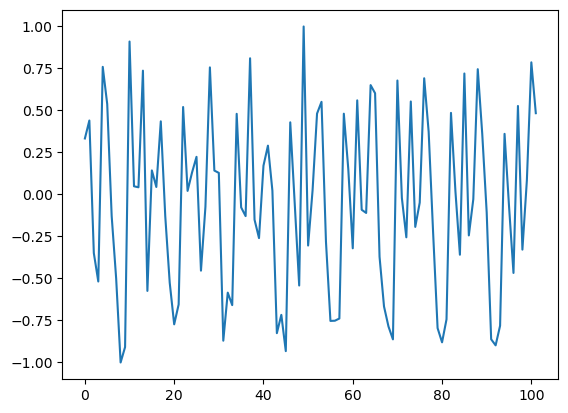

In [5]:
scaler = MinMaxScaler((0.3, np.pi-0.3))
conjunto_train = scaler.fit_transform(conjunto_train)
objetivo_train = 2*(objetivo_train-np.min(objetivo_train))/(np.max(objetivo_train)-np.min(objetivo_train)) - 1
plt.plot(objetivo_train)
plt.show()

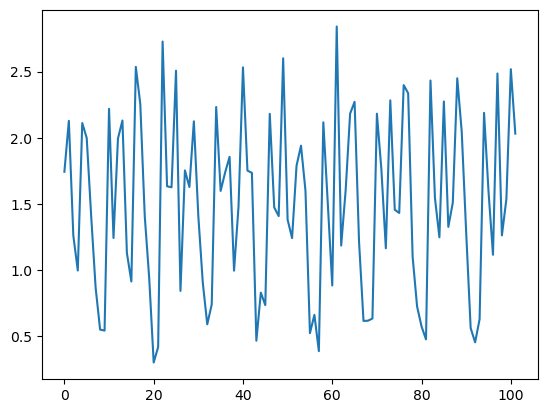

In [6]:
plt.plot(conjunto_train[:,0])
plt.show()

In [7]:
def circuitoRegresor_CodificacionAngular(n_qubits=1):
    qc = QuantumCircuit(n_qubits)
    
    inputs = ParameterVector("inputs",n_qubits)
    
    feature_map = QuantumCircuit(n_qubits)
    feature_map.h(range(n_qubits))
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
        
    for i in range(n_qubits-1):
        feature_map.cx(i,i+1)
    
    for i in range(n_qubits):
        feature_map.ry(inputs[i],i)
    
    
    ansatz = RealAmplitudes(n_qubits)
        
    
    
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    
    
    
    
    return feature_map.parameters, ansatz.parameters, qc, feature_map, ansatz

In [8]:
inputs, params, circuito, f1, f2 = circuitoRegresor_CodificacionAngular(window)

In [9]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [10]:
vqr = VQR(
    feature_map=f1,
    ansatz=f2,
    optimizer=L_BFGS_B(maxiter=30),
    callback=callback_graph,
    loss='absolute_error' ,
)

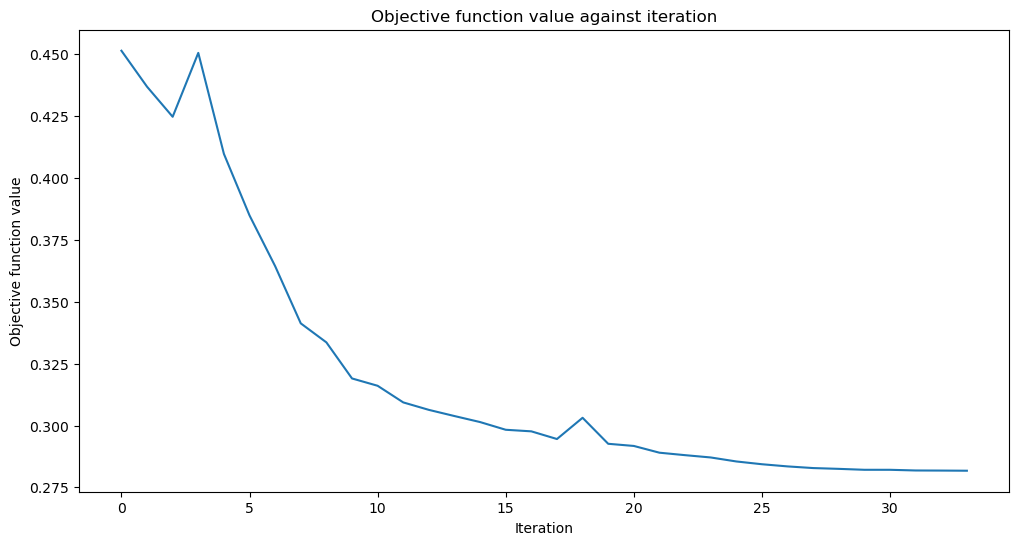

0.5302256177961525

In [11]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(conjunto_train, objetivo_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(conjunto_train, objetivo_train)

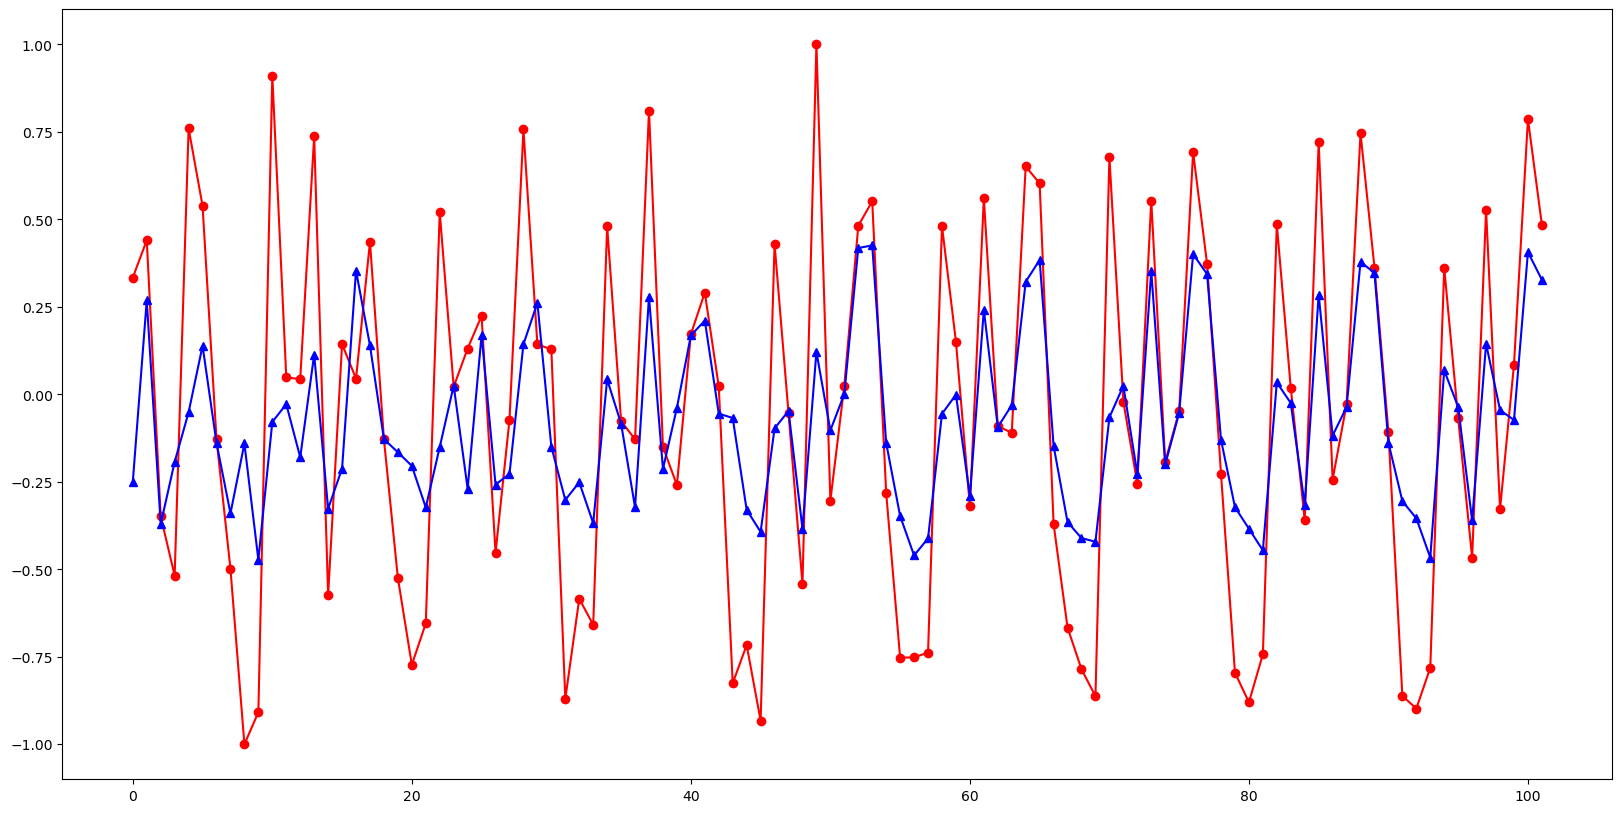

array([ 0.53224286,  0.91378835,  0.07645894,  0.92994939,  1.37321404,
        0.86513303,  1.05933331,  1.38294707, -0.5323484 , -0.24546588,
        2.32314749, -0.15749248,  0.4779483 ,  1.26072667,  1.00352512,
        0.68642298, -0.50158067,  1.25551429, -0.16673109,  0.89659074,
       -0.23473122, -0.29700436,  0.79895722,  0.9558385 ,  0.46917282,
        0.80026592,  0.90687463,  0.10556572,  0.2004493 ,  0.45596657,
        0.64486912,  0.43915881,  0.24576082,  0.2099566 ,  1.47987879,
        1.07459903, -0.02106433, -0.03573147,  0.0127058 , -0.02022152,
       -0.08954462,  0.12721834,  0.59111321,  0.09184802,  1.07362752,
        0.37587524, -0.09860855,  0.64618503])

In [12]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = vqr.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
vqr.weights

In [13]:
modeloEstimator = EstimatorQNN(
        circuit=circuito, input_params=inputs, weight_params=params
    )

In [14]:
regressor = NeuralNetworkRegressor(
    neural_network=modeloEstimator,
    loss='absolute_error' ,
    optimizer=COBYLA(maxiter=500),
    callback=callback_graph
)

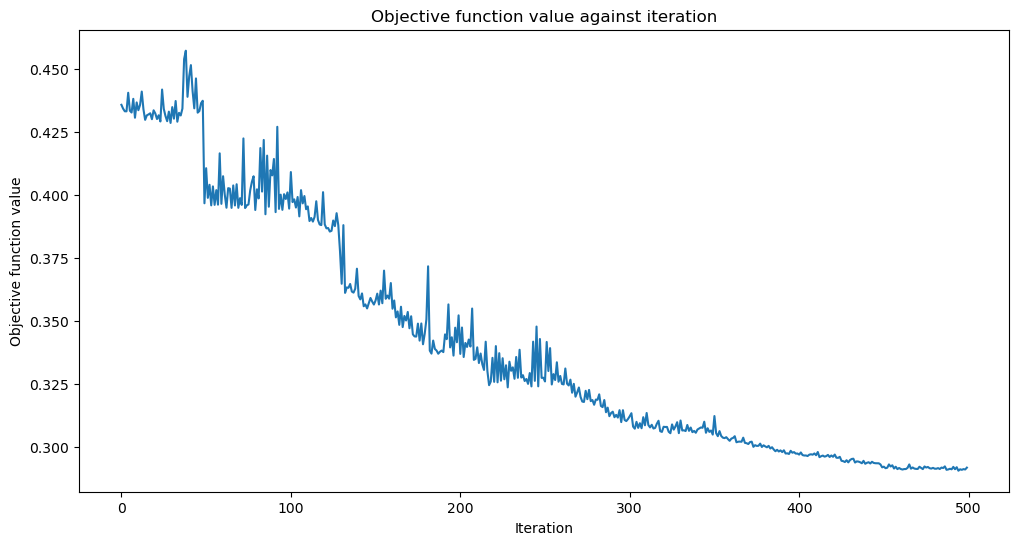

0.5388057271136101

In [15]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(conjunto_train, objetivo_train)
regressor.score(conjunto_train, objetivo_train)

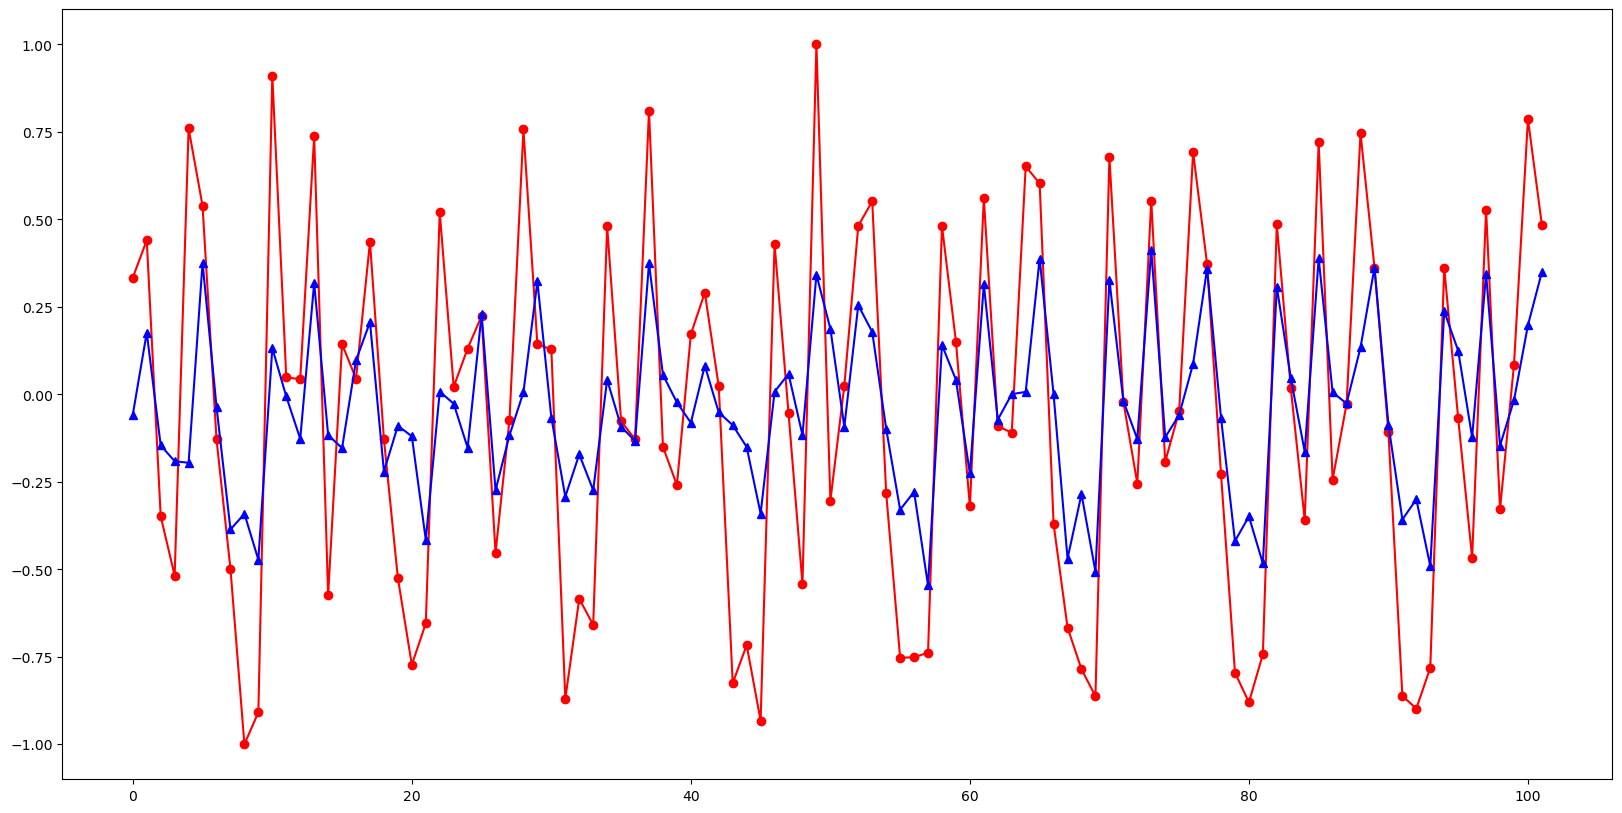

array([ 0.48521192,  1.00783691,  1.02985613,  0.22727111,  1.62426621,
        1.18274885,  0.87640802,  1.74564117,  0.09360637,  0.67717809,
       -0.53275556,  1.86475291,  1.57181883,  1.3475765 ,  0.94052067,
        0.19112684,  1.88272121, -0.06406107,  0.15623917,  0.26840699,
        0.28237051, -0.03221706,  1.76979214,  0.20747928,  0.99878734,
        0.44764921, -0.47701545,  0.71901322,  0.87296654, -0.34907199,
        0.14054017,  0.50454827,  0.22343412,  0.29376373, -0.01613989,
       -0.74634683,  0.00957625, -0.04094664,  0.10852922, -0.07280721,
        0.06123941, -0.05359655,  0.07792513,  0.131645  ,  0.60183747,
        0.58454482, -0.11452003,  1.36289575])

In [16]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor.weights

In [17]:
regressor2 = NeuralNetworkRegressor(
    neural_network=modeloEstimator,
    loss='absolute_error',
    optimizer=L_BFGS_B(maxiter=20),
    callback=callback_graph
)

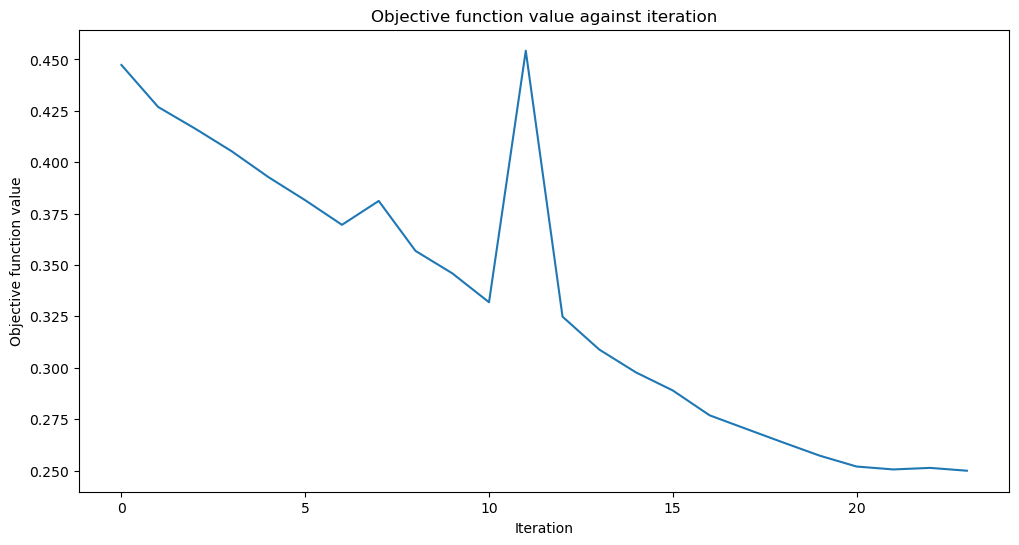

0.6253846349578255

In [18]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor2.fit(conjunto_train, objetivo_train)
regressor2.score(conjunto_train, objetivo_train)

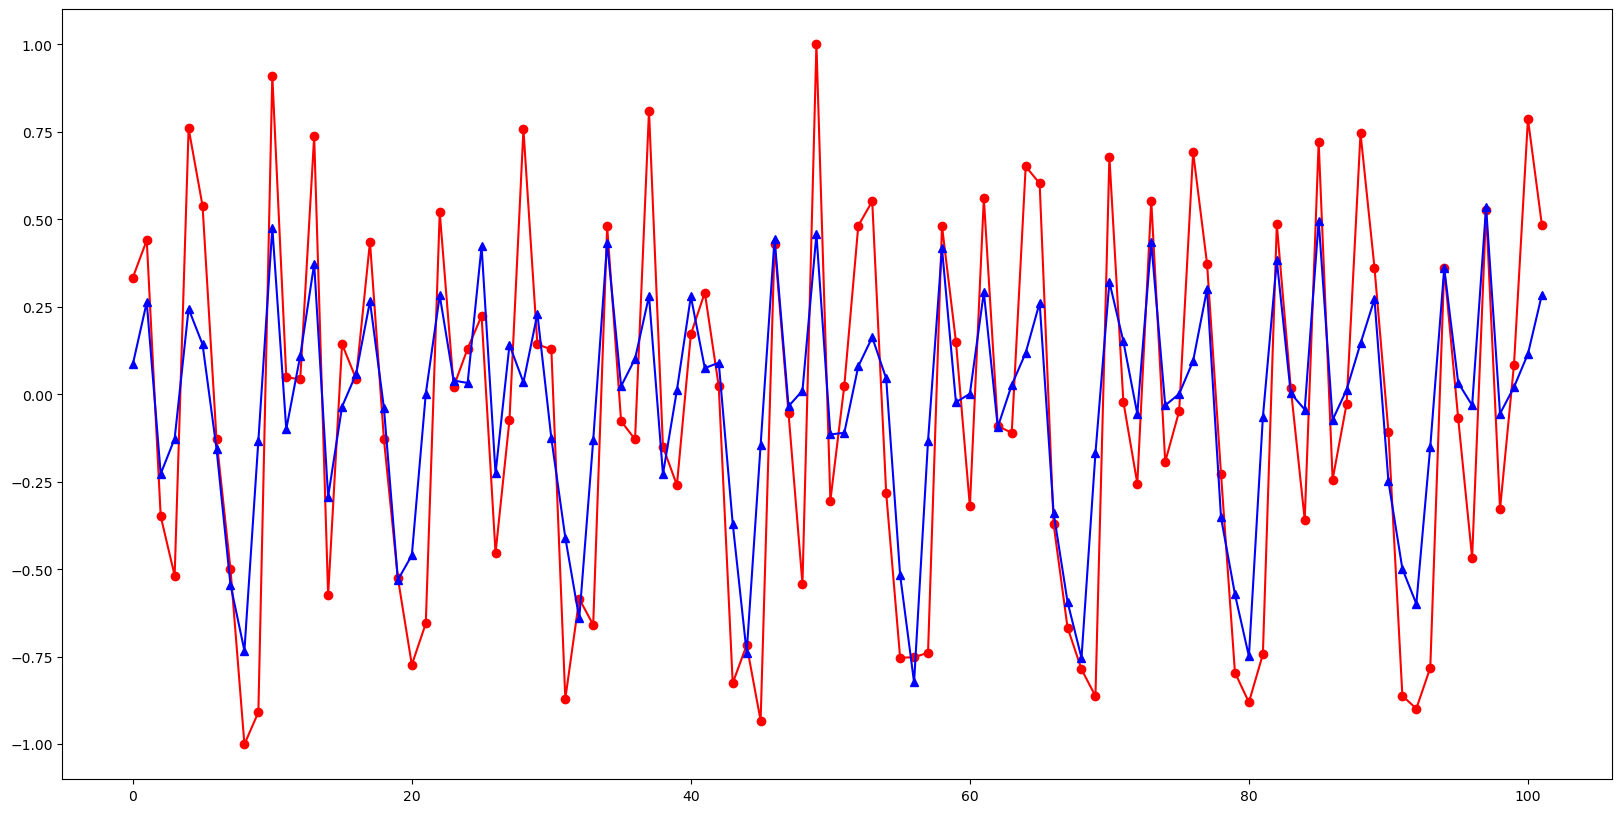

array([ 5.38454957e-02,  2.07528359e-01,  1.81224530e+00,  1.91486137e-01,
        5.09540678e-01,  2.43666243e-01,  9.41746091e-01,  4.38323004e-01,
        5.00194621e-01,  1.65263358e+00,  1.80927428e+00, -3.93362196e-01,
        1.54821432e+00,  1.11092828e-01,  3.28928508e-02,  1.55453188e-01,
        1.06460938e+00,  2.08622219e-01, -1.42715798e-01,  1.10330804e+00,
        6.97834407e-01,  3.48691165e-01,  1.11915925e+00,  6.03676434e-01,
        1.54487697e-02,  1.53066048e+00,  6.97528986e-01,  1.55910305e+00,
        2.56808122e-01,  8.00143423e-01, -5.51240154e-01, -1.42839933e-01,
        9.16766994e-01,  1.92374048e-01,  1.44528820e+00,  1.29392579e+00,
        1.67315152e+00,  1.66945950e+00,  4.95349567e-02, -1.38569977e-03,
       -3.56413880e-02,  3.17849871e-02,  8.57498519e-02, -6.24772533e-02,
       -1.08339294e-01,  2.46647249e-01,  2.93657501e-01,  3.77556813e-01])

In [19]:
espacio = np.arange(0,objetivo_train.shape[0])
y_ = regressor2.predict(conjunto_train)
plt.figure(figsize=(20,10))
plt.plot(espacio ,objetivo_train, marker='o',color='red', label='Verdaderos')
plt.plot(espacio,y_ , color='blue', marker='^',label='Predicciones') 
plt.show()
regressor2.weights